In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import copy
from torch.nn.functional import sigmoid
from pathlib import Path

In [81]:
# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 2. Data Loading and Exploration

## Here are some exploratory data analysis (EDA) steps you can perform on `combined_df`:

1. **Basic Statistics**:
    - Check the distribution of numerical columns.
    - Identify missing values.

    ```python
    print(combined_df.describe())
    print(combined_df.isnull().sum())
    ```

2. **Class Distribution**:
    - Analyze the distribution of the `isCancerous` column.

    ```python
    print(combined_df['isCancerous'].value_counts())
    combined_df['isCancerous'].value_counts().plot(kind='bar', title='Class Distribution')
    plt.show()
    ```

3. **Patient Analysis**:
    - Check the number of unique patients and their sample counts.

    ```python
    print(combined_df['patientID'].nunique())
    print(combined_df['patientID'].value_counts())
    ```

4. **Image Analysis**:
    - Verify if all images are unique.

    ```python
    print(combined_df['ImageName'].nunique() == len(combined_df))
    ```

5. **Correlation Analysis**:
    - Check for correlations between numerical columns.

    ```python
    print(combined_df.corr())
    sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm')
    plt.show()
    ```

6. **Data Distribution by Patient**:
    - Analyze the distribution of `isCancerous` by `patientID`.

    ```python
    patient_cancer_dist = combined_df.groupby('patientID')['isCancerous'].mean()
    patient_cancer_dist.plot(kind='hist', title='Cancerous Distribution by Patient')
    plt.show()
    ```

7. **Outlier Detection**:
    - Identify potential outliers in numerical columns.

    ```python
    sns.boxplot(data=combined_df[['InstanceID', 'patientID']])
    plt.show()
    ```

8. **Sample Visualization**:
    - Display random samples of images (if accessible).

    ```python
    sample_images = combined_df.sample(5)
    for _, row in sample_images.iterrows():
         img_path = os.path.join(image_dir, row['ImageName'])
         img = Image.open(img_path)
         plt.imshow(img)
         plt.title(f"isCancerous: {row['isCancerous']}")
         plt.axis('off')
         plt.show()
    ```

These steps will help you understand the dataset better and identify any issues or patterns.

In [82]:
pwd

'e:\\RMIT\\Fourth-Semester\\Computational-MachineLearning\\Assignment-2\\ColonCancer-Classification-Project\\notebooks'

In [83]:

# Paths to your CSV files
main_labels_path = '../data/data_labels_mainData.csv'  # Adjust this based on where you store it
extra_labels_path = '../data/data_labels_extraData.csv'

# Load the CSVs
main_df = pd.read_csv(main_labels_path)
extra_df = pd.read_csv(extra_labels_path)

# Display the first few rows
print("Main Data Labels:")
display(main_df.head())

print("\nExtra Data Labels:")
display(extra_df.head())




Main Data Labels:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0



Extra Data Labels:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [84]:
# Find common patient IDs between main_df and extra_df
common_patient_ids = set(main_df['patientID']).intersection(set(extra_df['patientID']))
print(f"Number of common patient IDs: {len(common_patient_ids)}")
print("Common patient IDs:", common_patient_ids)


Number of common patient IDs: 0
Common patient IDs: set()


In [85]:
# Add dummy column to extra_df so both have same structure
extra_df['cellType'] = None 

# Combine the two
combined_df = pd.concat([main_df, extra_df], ignore_index=True)

# Optional: Reset index
combined_df.reset_index(drop=True, inplace=True)
combined_df = combined_df.drop(columns=['cellTypeName','cellType'])
display(combined_df.head())

print("Main df shape:",main_df.shape)
print("Extra df shape:",extra_df.shape)
print("Combined shape:", combined_df.shape)

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


Main df shape: (9896, 6)
Extra df shape: (10384, 5)
Combined shape: (20280, 4)


In [86]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   20280 non-null  int64 
 1   patientID    20280 non-null  int64 
 2   ImageName    20280 non-null  object
 3   isCancerous  20280 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 633.9+ KB


In [87]:
# Check class balance in Main Data
print("isCancerous Distribution in Combined Data:")
print(combined_df['isCancerous'].value_counts())

# print("\ncellType Distribution in Main Data:")
# print(combined_df['cellType'].value_counts())

# Check class balance in Extra Data
# print("\nisCancerous Distribution in Extra Data:")
# print(combined_df['isCancerous'].value_counts())



isCancerous Distribution in Combined Data:
isCancerous
0    13211
1     7069
Name: count, dtype: int64


In [88]:
print(f"Unique patient IDs : {combined_df['patientID'].nunique()}")

Unique patient IDs : 98


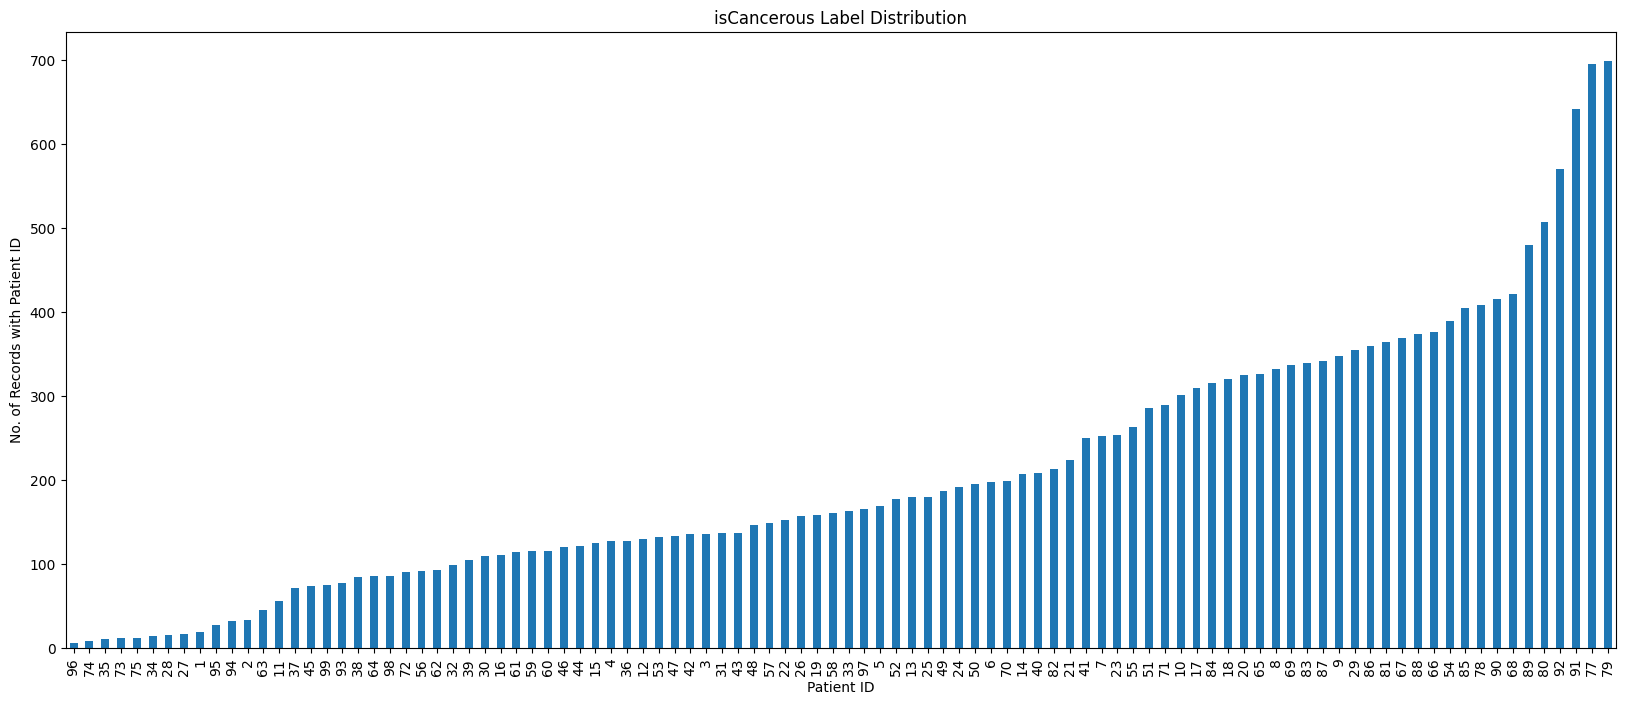

In [89]:
# Plot isCancerous distribution
sorted_data = combined_df['patientID'].value_counts().sort_values(ascending=True)


plt.figure(figsize=(20, 8))
sorted_data.plot(kind='bar')
plt.title('isCancerous Label Distribution')
plt.xlabel('Patient ID')
plt.ylabel('No. of Records with Patient ID')
plt.show()

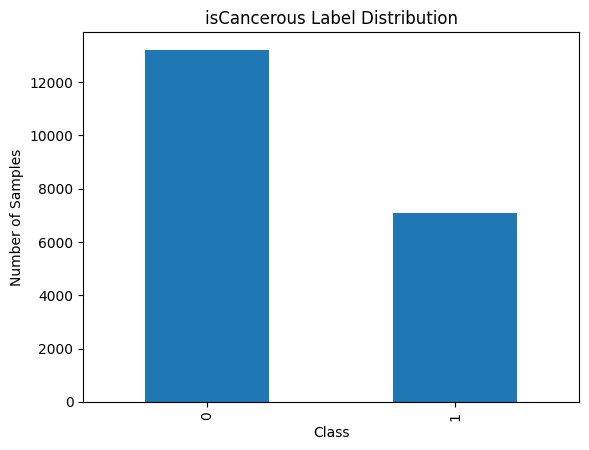

In [ ]:
import matplotlib.pyplot as plt

# Plot isCancerous distribution
combined_df['isCancerous'].value_counts().plot(kind='bar')
plt.title('isCancerous Label Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# # Plot cellType distribution
# combined_df['cellType'].value_counts().plot(kind='bar')
# plt.title('cellType Label Distribution')
# plt.xlabel('Cell Type')
# plt.ylabel('Number of Samples')
# plt.show()


Patient Cancerous Distribution:
patientID
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.207101
6     0.141414
7     0.241107
8     0.849398
9     0.425287
10    0.513245
Name: isCancerous, dtype: float64


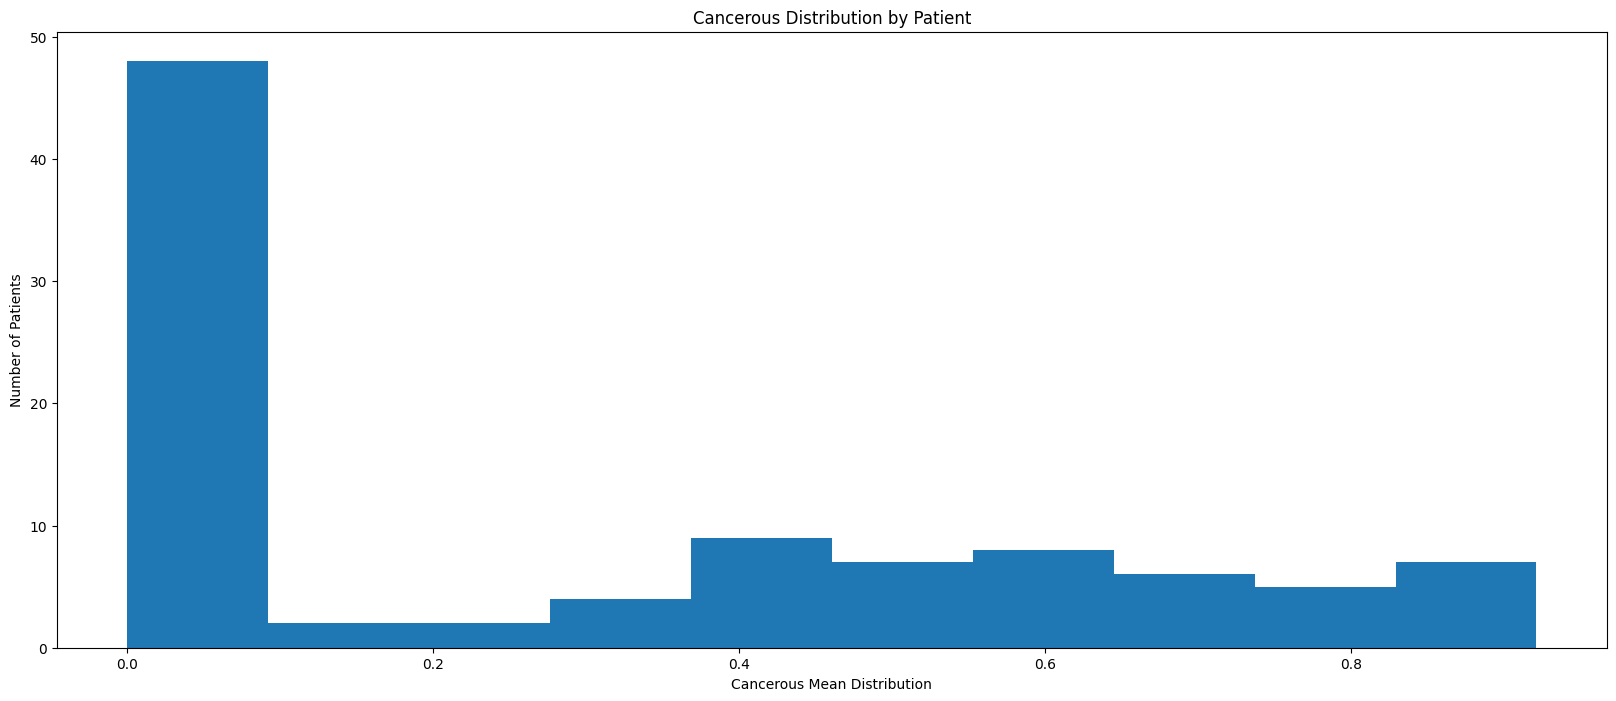

In [91]:
patient_cancer_dist = combined_df.groupby('patientID')['isCancerous'].mean()
print("Patient Cancerous Distribution:")
print(patient_cancer_dist.head(10))
plt.figure(figsize=(20, 8))
patient_cancer_dist.plot(kind='hist', title='Cancerous Distribution by Patient')
plt.xlabel('Cancerous Mean Distribution')
plt.ylabel('Number of Patients')
plt.show()

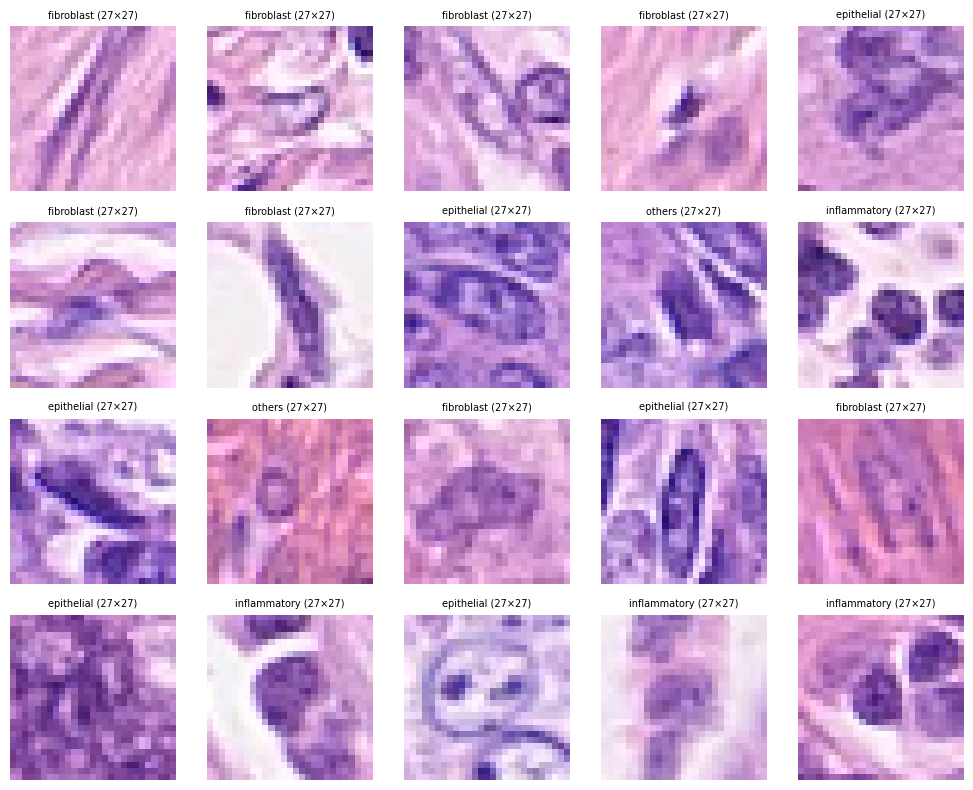

In [92]:
from pathlib import Path

# Sample Image Folder
image_dir = Path('../data/patch_images/')  # Adjust path as needed

# Display a few random samples
sample_images = main_df.sample(20)  # Randomly pick 20 images

# for idx, row in sample_images.iterrows():
#     img_path = os.path.join(image_dir, row['ImageName'])
#     img = Image.open(img_path)
#     plt.imshow(img)
#     plt.title(f"isCancerous: {row['isCancerous']}, CellType: {row.get('cellType', 'N/A')}")
#     plt.axis('off')
#     plt.show()

# plot
rows = 4
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 8)) 
for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    img_path = image_dir / row['ImageName']
    
    img = Image.open(img_path)
    width, height = img.size
    ax.imshow(img)
    ax.set_title(f"{row['cellTypeName']} ({width}×{height})", fontsize=7)
    
    ax.axis('off')

plt.tight_layout()
plt.show()




In [93]:
print(combined_df['ImageName'].nunique() == len(combined_df))

True


             InstanceID  patientID  isCancerous
InstanceID     1.000000   0.208105    -0.404783
patientID      0.208105   1.000000    -0.173420
isCancerous   -0.404783  -0.173420     1.000000


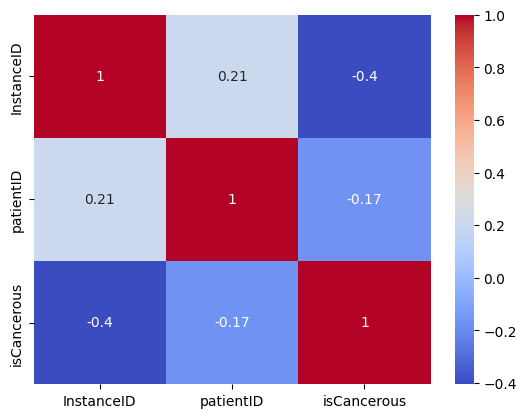

In [94]:
numrical_df = combined_df.select_dtypes(np.number).corr()
print(numrical_df)
sns.heatmap(numrical_df, annot=True, cmap='coolwarm')
plt.show()

**Preprocessing Notes:**

- **Normalization:** Apply transforms.ToTensor() followed by transforms.Normalize((0.5,), (0.5,)) to scale pixel values to [-1,1] for better CNN performance.
- **Label Encoding:** 
  - For Task 1 (Cancer detection): Use the `isCancerous` binary label (0/1).
  - For Task 2 (Cell type classification): Encode string cell types into integer classes.
- **Data Splitting:** Dataset will be split into 70% training, 15% validation, 15% testing, stratified by `isCancerous` labels to preserve class balance.


# 3. Data Preprocessing


## 3.1 Image Transformations (Preprocessing)

In [95]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


## 3.2 Create a Custom PyTorch Dataset Class

### For TASK 01 & TASK 02

In [96]:
class ColonCancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, task='cancer'):
        self.dataframe = dataframe           # DataFrame with labels
        self.img_dir = img_dir                # Folder where images are stored
        self.transform = transform            # Any transforms (e.g., normalize)
        self.task = task                      # 'cancer' (binary) or 'celltype' (multi-class)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get label
        if self.task == 'cancer':
            label = torch.tensor(self.dataframe.iloc[idx]['isCancerous'], dtype=torch.float32)
        elif self.task == 'celltype':
            label = torch.tensor(self.dataframe.iloc[idx]['cellTypeEncoded'], dtype=torch.long)
        
        return image, label


### For TASK 01

In [97]:
class CancerImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['ImageName']
        label = self.data.iloc[idx]['isCancerous']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


## Train/Validation/Test Split

In [98]:
# Split the main_df into train/validation/test

unique_patients = combined_df['patientID'].unique()
print(f"patients: {len(combined_df['patientID'])}")
print(f"Unique patients: {len(unique_patients)}")
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

train_df = combined_df[combined_df['patientID'].isin(train_patients)]
val_df = combined_df[combined_df['patientID'].isin(val_patients)]
test_df = combined_df[combined_df['patientID'].isin(test_patients)]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
# print(train_df)

patients: 20280
Unique patients: 98
Train set size: 14147
Validation set size: 3143
Test set size: 2990


In [116]:
from sklearn.model_selection import StratifiedGroupKFold

# Extract features for stratification
X = combined_df
y = combined_df['isCancerous']
groups = combined_df['patientID']

# Initialize splitter
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Get the first split (train/val_test)
train_idx, temp_idx = next(sgkf.split(X, y, groups))

train_df = combined_df.iloc[train_idx].reset_index(drop=True)
temp_df = combined_df.iloc[temp_idx].reset_index(drop=True)

# Now split temp into validation and test sets
# Recalculate y and groups for temp split
y_temp = temp_df['isCancerous']
groups_temp = temp_df['patientID']

sgkf_temp = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)
val_idx, test_idx = next(sgkf_temp.split(temp_df, y_temp, groups_temp))

val_df = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 15747
Validation set size: 1601
Test set size: 2932


In [118]:
print(f"Train set size: {train_df['isCancerous'].value_counts()}")
print(f"Validation set size: {val_df['isCancerous'].value_counts()}")   
print(f"Test set size: {test_df['isCancerous'].value_counts()}")


Train set size: isCancerous
0    10129
1     5618
Name: count, dtype: int64
Validation set size: isCancerous
0    974
1    627
Name: count, dtype: int64
Test set size: isCancerous
0    2108
1     824
Name: count, dtype: int64


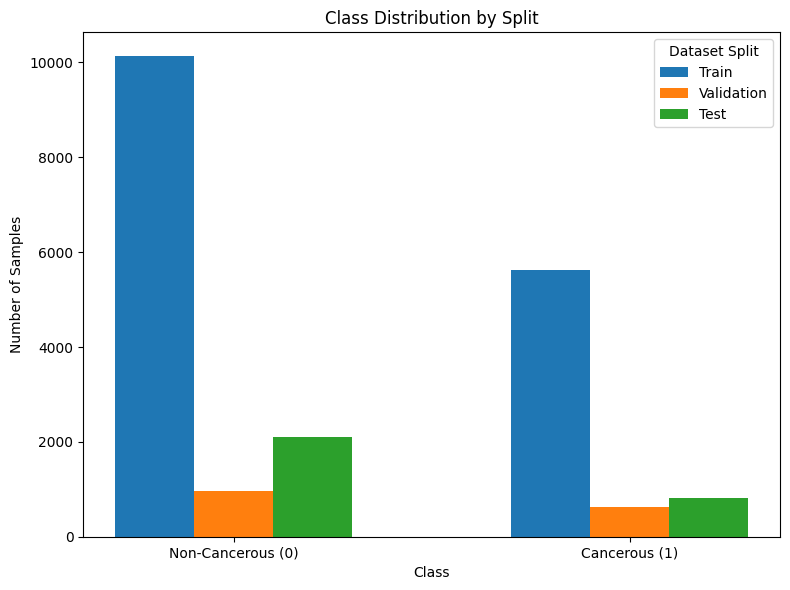

In [117]:
# Prepare data for grouped bar plot
class_labels = ['Non-Cancerous (0)', 'Cancerous (1)']
split_names = ['Train', 'Validation', 'Test']

# Prepare data for stacked bar plot
split_names = ['Train', 'Validation', 'Test']
split_dfs = [train_df, val_df, test_df]
class_counts = [df['isCancerous'].value_counts().sort_index() for df in split_dfs]

# Ensure both classes (0 and 1) are present in each split
counts_0 = [counts.get(0, 0) for counts in class_counts]
counts_1 = [counts.get(1, 0) for counts in class_counts]
counts = np.array([counts_0, counts_1])  # shape: (2, 3)

bar_width = 0.2
ind = np.arange(len(class_labels))

plt.figure(figsize=(8, 6))
for i, split in enumerate(split_names):
    plt.bar(ind + i * bar_width, counts[:, i], bar_width, label=split)

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution by Split')
plt.xticks(ind + bar_width, class_labels)
plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()


## Create Datasets and DataLoaders

In [101]:
train_dataset = CancerImageDataset(train_df, image_dir, transform)
val_dataset = CancerImageDataset(val_df, image_dir, transform)
test_dataset = CancerImageDataset(test_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# 4. Baseline model

In [102]:
# class CancerClassifierCNN(nn.Module):
#     def __init__(self):
#         super(CancerClassifierCNN, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # input: [3, 27, 27] → [16, 27, 27]
#         self.pool = nn.MaxPool2d(2, 2)                            # → [16, 13, 13]
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # → [32, 13, 13] → [32, 6, 6]

#         # Fully connected layer
#         self.fc1 = nn.Linear(32 * 6 * 6, 1)   # binary classification → 1 output neuron

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))   # conv1 + relu + pool
#         x = self.pool(F.relu(self.conv2(x)))   # conv2 + relu + pool
#         x = x.view(-1, 32 * 6 * 6)             # flatten
#         x = self.fc1(x)                        # final dense layer (no sigmoid here!)
#         return x


class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)


In [103]:
# model = CancerClassifierCNN()

# criterion = nn.BCEWithLogitsLoss()               # binary classification
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


## 5. Train the Model

In [104]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25):
    train_losses = []
    val_losses = []
    val_accuracies = []

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    return model, train_losses, val_losses, val_accuracies


In [105]:
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()

In [106]:
def plot_loss_and_accuracy(train_losses, val_losses, val_accuracies, title="Training Summary"):
    import matplotlib.pyplot as plt

    epochs = range(1, len(train_losses) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(epochs, train_losses, label='Train Loss')
    axs[0].plot(epochs, val_losses, label='Val Loss')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(epochs, val_accuracies, label='Val Accuracy', color='green')
    axs[1].set_title('Validation Accuracy Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Epoch [1/100] | Train Loss: 0.3265 | Val Loss: 0.4758 | Val Acc: 77.95%
Epoch [2/100] | Train Loss: 0.2852 | Val Loss: 0.3868 | Val Acc: 83.33%
Epoch [3/100] | Train Loss: 0.2553 | Val Loss: 0.3877 | Val Acc: 83.26%
Epoch [4/100] | Train Loss: 0.2376 | Val Loss: 0.4130 | Val Acc: 81.10%
Epoch [5/100] | Train Loss: 0.2112 | Val Loss: 0.4199 | Val Acc: 81.29%
Epoch [6/100] | Train Loss: 0.1811 | Val Loss: 0.3511 | Val Acc: 85.43%
Epoch [7/100] | Train Loss: 0.1302 | Val Loss: 0.4493 | Val Acc: 83.36%
Epoch [8/100] | Train Loss: 0.0985 | Val Loss: 0.5160 | Val Acc: 83.55%
Epoch [9/100] | Train Loss: 0.0605 | Val Loss: 0.7215 | Val Acc: 82.21%
Epoch [10/100] | Train Loss: 0.0488 | Val Loss: 0.7447 | Val Acc: 83.49%
Epoch [11/100] | Train Loss: 0.0264 | Val Loss: 1.2692 | Val Acc: 83.61%
Epoch [12/100] | Train Loss: 0.0243 | Val Loss: 1.1407 | Val Acc: 82.60%
Epoch [13/100] | Train Loss: 0.0219 | Val Loss: 1.2880 | Val Acc: 80.69%
Epoch [14/100] | Train Loss: 0.0218 | Val Loss: 1.5269 | Val

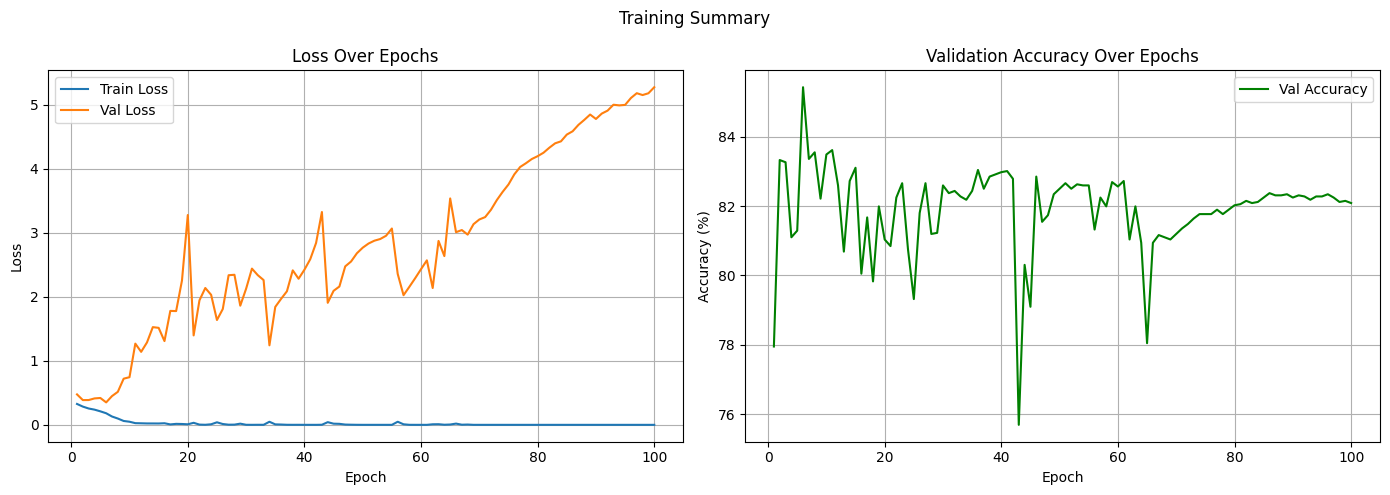

In [107]:
model = CNNBaseline()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, device, num_epochs=100
)

plot_loss_and_accuracy(train_losses, val_losses, val_accuracies)


Validation Performance:

Validation Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.81      0.86      0.83      1655
    Cancerous       0.83      0.78      0.80      1488

     accuracy                           0.82      3143
    macro avg       0.82      0.82      0.82      3143
 weighted avg       0.82      0.82      0.82      3143



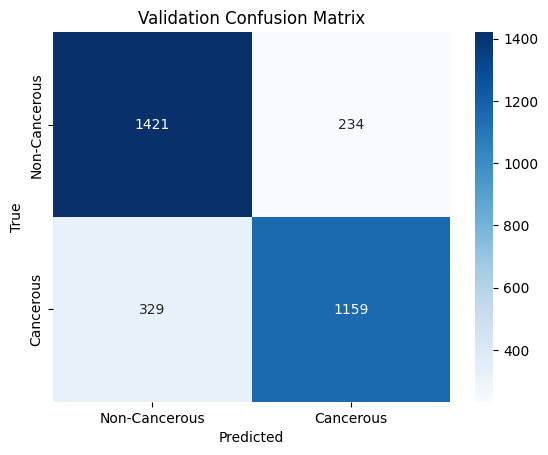

Test Performance:

Test Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.93      0.89      0.91      2305
    Cancerous       0.68      0.76      0.72       685

     accuracy                           0.86      2990
    macro avg       0.80      0.83      0.81      2990
 weighted avg       0.87      0.86      0.86      2990



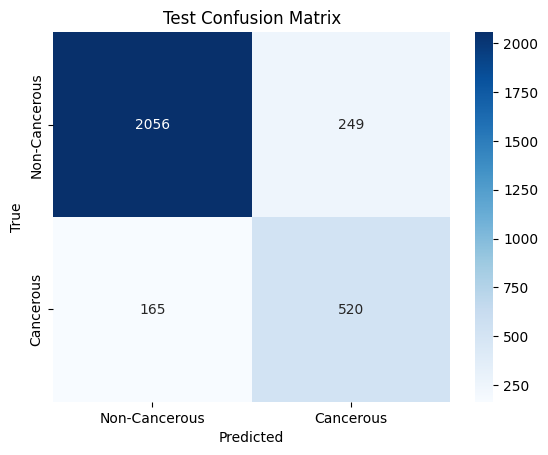

In [108]:
def evaluate(model, loader, name='Validation'):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            preds = (outputs > 0.5).astype(int).flatten()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Cancerous', 'Cancerous']))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancerous', 'Cancerous'], yticklabels=['Non-Cancerous', 'Cancerous'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

print("Validation Performance:")
evaluate(model, val_loader, name='Validation')

print("Test Performance:")
evaluate(model, test_loader, name='Test')


## 6. Advanced Model Development (CNN v2)

### 6.1 Motivation for Model Improvements
From the baseline CNN results, we observed the following:

- **Validation loss increased** after epoch 6, while training loss continued to decrease. This is a sign of **overfitting**, where the model learns to perform well on the training data but fails to generalize to unseen data.
- The **recall and F1-score for the cancerous class (label 1)** were lower than for the non-cancerous class. Specifically, the test recall for cancerous cells was **0.82**, compared to **0.93** for non-cancerous. This suggests a **bias toward the majority class** and potential difficulty in detecting cancerous cases accurately.

These insights motivate the following enhancements in the next model version (CNN v2):
- **Batch Normalization** to improve training stability and reduce overfitting.
- **Dropout tuning** to further regularize the model and prevent overfitting.
- **Data augmentation** to improve generalization by increasing the diversity of training examples.
- **Class imbalance handling** using `BCEWithLogitsLoss` with a positive weight term to emphasize correct classification of cancerous cells.

### 6.2 Model Architecture Enhancements
In this version, we enhanced the CNN architecture to improve generalization and training stability:
- **Batch Normalization** is added after each convolutional layer to standardize activations and reduce internal covariate shift.
- **Dropout** (0.4) is applied before the final layer to reduce overfitting.
- **Sigmoid activation is removed** in the output layer so that `BCEWithLogitsLoss` can be used, which is numerically more stable than combining `Sigmoid` + `BCELoss`.

In [109]:
class CNNV2(nn.Module):
    def __init__(self):
        super(CNNV2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),  # you can try 0.3 or 0.5 too
            nn.Linear(256, 1)  # no Sigmoid here!
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)  # output raw logits


### 6.3: Training Data Augmentation
To improve model generalization, we applied the following transformations to training images:
- **RandomHorizontalFlip**: simulates variations in sample orientation.
- **RandomRotation (±15°)**: helps the model handle rotated cells.
- **ColorJitter**: introduces slight brightness and contrast variations, accounting for lighting inconsistencies.

These augmentations expand the effective size of the training set and help prevent overfitting. No augmentation was applied to validation and test images to ensure fair evaluation.

In [120]:
# Augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Validation/Test set — NO augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [121]:
train_dataset_adv = CancerImageDataset(train_df, image_dir, transform=train_transform)
val_dataset_adv = CancerImageDataset(val_df, image_dir, transform=val_test_transform)
test_dataset_adv = CancerImageDataset(test_df, image_dir, transform=val_test_transform)

train_loader_adv = DataLoader(train_dataset_adv, batch_size=32, shuffle=True)
val_loader_adv = DataLoader(val_dataset_adv, batch_size=32, shuffle=False)
test_loader_adv = DataLoader(test_dataset_adv, batch_size=32, shuffle=False)

### 6.4: Handle Class Imbalance with BCEWithLogitsLoss
Our dataset contains more non-cancerous images than cancerous ones. To address this imbalance, we used `BCEWithLogitsLoss` with a calculated `pos_weight`, which emphasizes correct classification of the minority (cancerous) class. 

The positive weight is computed as the ratio of negative to positive samples in the training set. Additionally, the output activation was handled externally using `Sigmoid()` during evaluation for numerical stability.


In [122]:
# Count class distribution
num_pos = train_df['isCancerous'].sum()
num_neg = len(train_df) - num_pos

# Calculate pos_weight = num_neg / num_pos
pos_weight = torch.tensor([num_neg / num_pos]).to(device)
print(f"Positive weight for cancerous class: {pos_weight.item():.2f}")


Positive weight for cancerous class: 1.80


In [123]:
# update loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

### 6.5: Training and Evaluation
The improved model (CNN v2) was trained for 20 epochs. We tracked training and validation loss to monitor overfitting and used the best-performing model based on validation loss. 

The final model was evaluated using accuracy, precision, recall, and F1-score. We specifically observed improvements in the cancerous class metrics, demonstrating the effectiveness of our architectural and training adjustments.


In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNV2().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses_adv = []
val_losses_adv = []
val_accuracies_adv = []

best_val_loss = float('inf')
best_model_state = None

num_epochs = 100

for epoch in range(num_epochs):  
    model.train()
    running_loss = 0.0
    for images, labels in train_loader_adv:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader_adv)
    train_losses_adv.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader_adv:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader_adv)
    val_accuracy = 100 * correct / total
    val_losses_adv.append(avg_val_loss)
    val_accuracies_adv.append(val_accuracy)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/100], Train Loss: 0.7013, Val Loss: 0.9307, Val Acc: 75.27%
Epoch [2/100], Train Loss: 0.4624, Val Loss: 0.5697, Val Acc: 82.01%
Epoch [3/100], Train Loss: 0.4576, Val Loss: 0.5477, Val Acc: 85.70%
Epoch [4/100], Train Loss: 0.4288, Val Loss: 0.5144, Val Acc: 85.07%
Epoch [5/100], Train Loss: 0.4406, Val Loss: 0.5357, Val Acc: 85.26%
Epoch [6/100], Train Loss: 0.4348, Val Loss: 0.6883, Val Acc: 83.82%
Epoch [7/100], Train Loss: 0.4213, Val Loss: 0.6000, Val Acc: 83.20%
Epoch [8/100], Train Loss: 0.4099, Val Loss: 0.5379, Val Acc: 85.38%
Epoch [9/100], Train Loss: 0.4064, Val Loss: 0.5445, Val Acc: 83.82%
Epoch [10/100], Train Loss: 0.4072, Val Loss: 0.6013, Val Acc: 86.32%
Epoch [11/100], Train Loss: 0.4112, Val Loss: 0.5315, Val Acc: 84.70%
Epoch [12/100], Train Loss: 0.3984, Val Loss: 0.5262, Val Acc: 83.45%
Epoch [13/100], Train Loss: 0.3940, Val Loss: 0.5268, Val Acc: 85.82%
Epoch [14/100], Train Loss: 0.3823, Val Loss: 0.5691, Val Acc: 81.01%
Epoch [15/100], Train Loss: 0

In [125]:
# # Initialize model
# model = CNNV2().to(device)

# # Count positives and negatives (if not already done)
# # num_pos = train_df['isCancerous'].sum()
# # num_neg = len(train_df) - num_pos
# # pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

# # Loss function (class imbalance handling)
# # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Optimizer with weight decay (L2 regularization)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Scheduler: reduce LR when val loss plateaus
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# # Tracking variables
# train_losses = []
# val_losses = []
# best_val_loss = float('inf')
# best_model_state = None
# patience = 5
# counter = 0
# max_epochs = 50  # Feel free to adjust this

# # Training loop
# for epoch in range(max_epochs):
#     model.train()
#     running_loss = 0.0

#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device).unsqueeze(1)

#         optimizer.zero_grad()
#         outputs = model(images)  # No sigmoid here
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     avg_train_loss = running_loss / len(train_loader)
#     train_losses.append(avg_train_loss)

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images = images.to(device)
#             labels = labels.to(device).unsqueeze(1)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)

#     # Step the scheduler
#     scheduler.step(avg_val_loss)

#     # Early stopping logic
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_model_state = copy.deepcopy(model.state_dict())
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print(f"Early stopping triggered at epoch {epoch+1}")
#             break

#     print(f"Epoch [{epoch+1}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


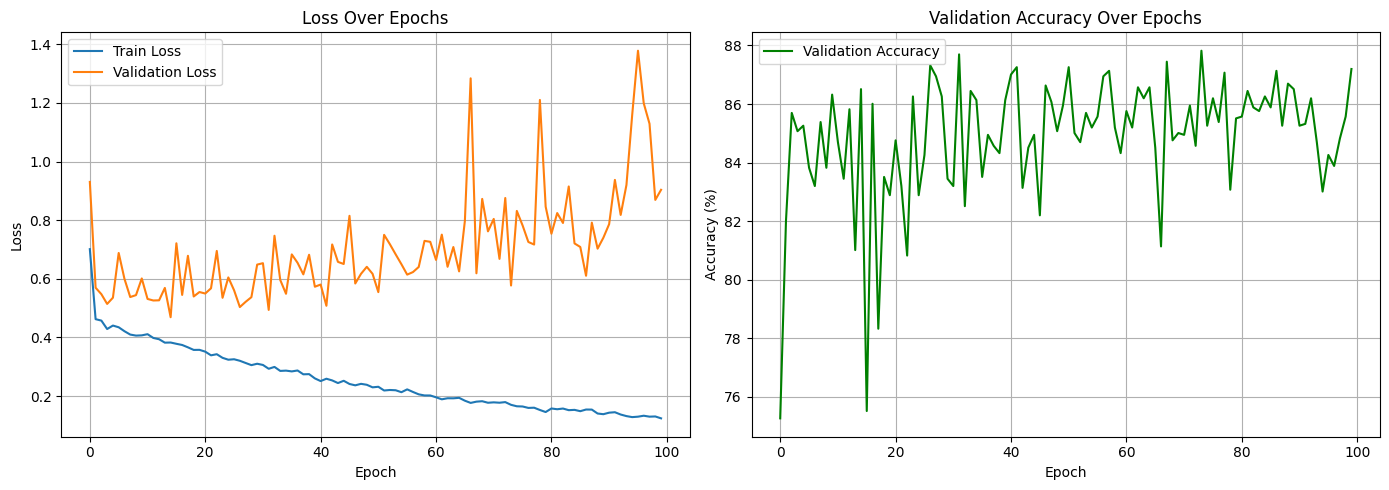

In [129]:
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs (CNN v2)')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_adv, label='Train Loss')
plt.plot(val_losses_adv, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_adv, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [130]:
def evaluate(model, loader, name='Validation'):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)  # logits
            probs = sigmoid(outputs).cpu().numpy()  # apply sigmoid here
            preds = (probs > 0.5).astype(int).flatten()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Cancerous', 'Cancerous']))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Cancerous', 'Cancerous'],
                yticklabels=['Non-Cancerous', 'Cancerous'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

Validation Performance:

Validation Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.90      0.87      0.89       974
    Cancerous       0.81      0.85      0.83       627

     accuracy                           0.86      1601
    macro avg       0.86      0.86      0.86      1601
 weighted avg       0.87      0.86      0.86      1601



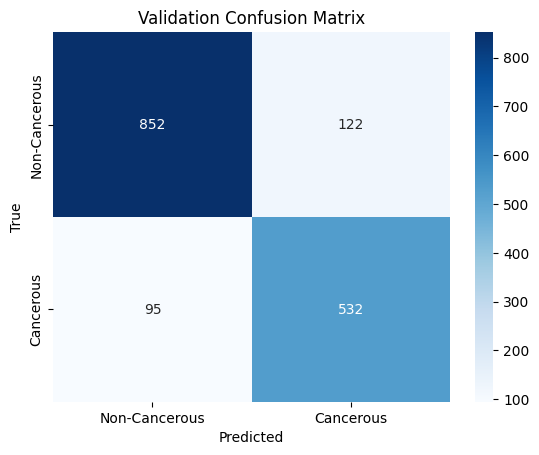

Test Performance:

Test Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.97      0.86      0.91      2108
    Cancerous       0.72      0.93      0.81       824

     accuracy                           0.88      2932
    macro avg       0.84      0.89      0.86      2932
 weighted avg       0.90      0.88      0.88      2932



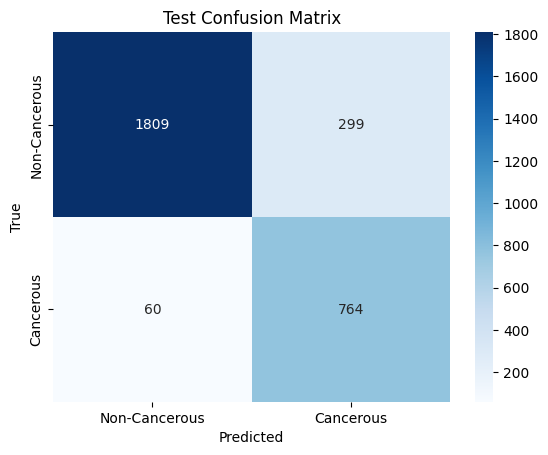

In [131]:
model.load_state_dict(best_model_state)
print("Validation Performance:")
evaluate(model, val_loader_adv, name='Validation')

print("Test Performance:")
evaluate(model, test_loader_adv, name='Test')
